In [1]:
#Defining some Classic Variables and Values

environment_variables = {0: 'road', 1: 'footpath', 2: 'playground', 3: 'passive'}
theme_variables = {-1: 'naturalistic', -2: 'manicured'}


In [2]:
#Action space variables
#Look into action masking for possible actions

# Missing Colour, Trunk texture for NOW
class plantSpecies():
    def __init__(self, species_id, type, height, radius, sun_requirements, attracted_species, fragrant, fruit_bearing, texture) -> None:
        self.species_id = species_id
        self.type = type
        self.height = height
        self.radius = radius
        self.sun_requirements = sun_requirements
        self.attracted_species = attracted_species
        self.fragrant = fragrant
        self.fruit_bearing = fruit_bearing
        self.texture = texture


species1 = plantSpecies(100, 'shrub', 0.5, 2, 'low', None, False, False, 'thin')
species2 = plantSpecies(101, 'shrub', 0.75, 3, 'high', 'butterfly', True, True, 'medium')
species3 = plantSpecies(102, 'shrub', 1, 3, 'low', 'bee', False, True, 'coarse')
species4 = plantSpecies(103, 'tree', 10, 2, 'high', None, None, True, None)
species5 = plantSpecies(104, 'tree', 15, 3, 'high', None, None, True, None)
species6 = plantSpecies(105, 'tree', 20, 4, 'high', None, None, True, None)

In [3]:
import numpy
# Define Set Environment
def create_grid(type, max_size, shape_size, context_value, shape_value):
    grid = np.full((max_size, max_size), context_value)
    
    start_x_value = (max_size - shape_size[0])//2
    start_y_value = (max_size - shape_size[1])//2
    
    if type == 'square':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    elif type == 'circle':
        for x in range(max_size):
            for y in range(max_size):
                if (x-start_x_value) **2 + (y - start_y_value)**2 <= shape_size[0]**2:
                    grid[y,x] = shape_value

    elif type == 'rectangle':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    return grid

In [66]:
import numpy as np

def compute_distances(grid_size, planting_size):    
    row_start = (grid_size - planting_size[1]) // 2
    row_end = row_start + planting_size[1] - 1
    col_start = (grid_size - planting_size[0]) // 2
    col_end = col_start + planting_size[0] - 1
    
    # Create a distance array
    distances = np.zeros((grid_size, grid_size))
    
    for r in range(grid_size):
        for c in range(grid_size):
            # If the cell is inside the 60x60 block, the distance is 0
            if row_start <= r <= row_end and col_start <= c <= col_end:
                distances[r, c] = 0
            else:
                # Compute the Manhattan distance to the closest edge of the 60x60 block
                dist_r = min(abs(r - row_start), abs(r - row_end))
                dist_c = min(abs(c - col_start), abs(c - col_end))
                distances[r, c] = dist_r + dist_c
    
    return distances

# Example usage:
grid_size = 100
center_size = (80, 60)

distances = compute_distances(grid_size, center_size)
print(distances)

[[30. 29. 28. ... 28. 29. 30.]
 [29. 28. 27. ... 27. 28. 29.]
 [28. 27. 26. ... 26. 27. 28.]
 ...
 [28. 27. 26. ... 26. 27. 28.]
 [29. 28. 27. ... 27. 28. 29.]
 [30. 29. 28. ... 28. 29. 30.]]


In [202]:
import numpy as np
import gym
from gym import spaces

# Environment Class
class customGridEnv(gym.Env):
    def __init__(self, grid, planting_size, agent_position=None):
        self.grid_size= grid.shape
        self.planting_size = planting_size
        self.values = [-1, -2, 100, 101, 102, 103, 104, 105, 0, 1, 2, 3]
        self.values_to_index = {value: index for index, value in enumerate(self.values)}
        
        self.action_to_value = {0: 'moveup', 1: 'moveleft', 2: 'moveright', 3: 'movedown', 4:'movediagtr', 5:"movediagbl", 6:"movediagbr", 7:"movediagtl"}
        self.id_to_species = {100: species1, 101: species2, 102:species3, 103:species4, 104:species5, 105:species6}

        self.agent_position = agent_position if agent_position else self.randomise_starting_position(self.grid_size[0], self.planting_size)
        self.initial_agent_position = agent_position
        
        self.reward_space = compute_distances(self.grid_size[0], planting_size)
        # Initialize your grid
        self.grid = grid
        self.initial_grid = grid.copy()

        self.action_space = spaces.Discrete(len(self.action_to_value)) 
        self.visited = np.zeros(self.grid_size, dtype=bool)  # False means unvisited
        
        obv_spaces = {
            'grid': spaces.Box(low=-2, high=105, shape=self.grid_size),  # The grid itself
            'visited': spaces.Box(low=0, high=1, shape=self.grid_size),  # The visited cells (0 or 1)
            'reward': spaces.Box(low=-np.inf, high=np.inf, shape=self.grid_size),  # The reward space
            'agent_location': spaces.Box(low=0, high=max(self.grid_size[0], self.grid_size[1]), shape=(2,)),  # Agent's (x, y) position
        }

        self.observation_space = spaces.Dict(obv_spaces)


    def randomise_starting_position(self, grid_size, planting_size): 

        start_x_value = (grid_size - planting_size[0]) // 2
        start_y_value = (grid_size - planting_size[1]) // 2
        end_x_value = start_x_value + planting_size[0]
        end_y_value = start_y_value + planting_size[1]

        while True:
            x = np.random.randint(0, grid_size, size=1)[0]
            y = np.random.randint(0, grid_size, size=1)[0]

            if not start_x_value <= x <= end_x_value and not start_y_value <= y <= end_y_value:
                return (x,y)
        

    def reset(self):
        self.agent_position = self.initial_agent_position if self.initial_agent_position else self.randomise_starting_position(self.grid_size[0], self.planting_size)
        self.visited = np.zeros(self.grid_size, dtype=bool)  # False means unvisited
        self.grid = self.initial_grid.copy()  # Reset the grid
        return self.get_observation()


    def step(self, action):
        reward = 0
        action_to_take = self.action_to_value[int(action)]

        if action_to_take in ['moveup', 'movedown', 'moveleft', 'moveright', "movediagbl", "movediagbr", "movediagtl", "movediagtr"]:
            reward += self.calculate_movement_reward(action_to_take)

        terminated = np.all(self.visited) or self.grid[self.agent_position[1], self.agent_position[0]] in [-1, -2]
        return self.get_observation(), reward, terminated,  {}

    
    def calculate_movement_reward(self, action_to_take):
        prev_x, prev_y = self.agent_position


        if action_to_take == 'moveup' and prev_y > 0:
            self.agent_position = (prev_x, prev_y-1)

        elif action_to_take == 'movedown' and prev_y < self.grid_size[1]-1:
            self.agent_position = (prev_x, prev_y+1)

        elif action_to_take == 'moveleft' and prev_x > 0:
            self.agent_position = (prev_x-1, prev_y)

        elif action_to_take == 'moveright' and prev_x < self.grid_size[0]-1:
            self.agent_position = (prev_x+1, prev_y)
        
        elif action_to_take == 'movediagtr' and prev_x < self.grid_size[0]-1 and prev_y > 0:
            self.agent_position = (prev_x+1, prev_y-1)

        elif action_to_take == 'movediagtl' and prev_x > 0 and prev_y > 0:
            self.agent_position = (prev_x-1, prev_y-1)
        
        elif action_to_take == 'movediagbl' and prev_x > 0 and prev_y < self.grid_size[1]-1:
            self.agent_position = (prev_x-1, prev_y+1)
        
        elif action_to_take == 'movediagbr' and prev_x < self.grid_size[0]-1 and prev_y < self.grid_size[1]-1:
            self.agent_position = (prev_x+1, prev_y+1)
        
        else:
            # Out of bounds
            return -50
        
        # Reward for visiting
        if self.visited[self.agent_position[1], self.agent_position[0]]:
            return -10

        else:
            self.visited[self.agent_position[1], self.agent_position[0]] = True
            return 1/((self.reward_space[self.agent_position[1], self.agent_position[0]]) + 1)
        

    def get_observation(self):
        return {
            'grid': self.grid.astype(np.float32),
            'visited': self.visited.astype(np.float32),
            'reward': self.reward_space.astype(np.float32),
            'agent_location': np.array(self.agent_position, dtype=np.int32)
        }

In [264]:
from stable_baselines3 import PPO

# Define your environment
env = customGridEnv(create_grid('square', 100, (80, 80), 0, -1), (80,80))
eval_env = customGridEnv(create_grid('square', 100, (60, 60), 0, -1), (60,60), (0,50))

In [265]:
# Create the PPO model
model2 = PPO("MultiInputPolicy", 
             env, 
             n_steps=15,
             n_epochs= 10,
             verbose=0)

c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 25`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 25
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=25 and n_envs=1)
  warnings.warn(


In [266]:
# Train the model
max_runs = 1000
total_timesteps = max_runs* 15


model2.learn(total_timesteps=total_timesteps)
avg_reward = evaluate_policy(model2, eval_env, total_timesteps)
print(f"Average Reward: {avg_reward}")

Average Reward: -1123009.8327973092


In [ ]:
# Train the model
max_runs = 100
total_timesteps = max_runs* 25

for epoch in range(max_runs):
    model2.learn(total_timesteps=total_timesteps, log_interval=total_timesteps)
    avg_reward = evaluate_policy(model2, eval_env, total_timesteps)
    print(f"Epoch {epoch+1} done. Average Reward: {avg_reward}")

1000 steps with total reward: -46959.01936874615


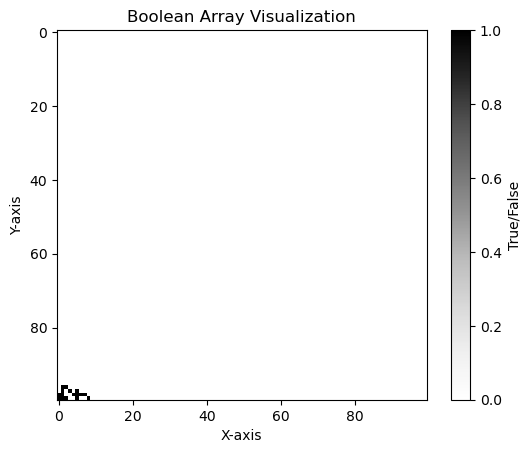

In [281]:
import numpy as np
import matplotlib.pyplot as plt

obs = env.reset()

total_reward = 0
steps = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, info = env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    steps += 1

    if done:
        break

print(f"{steps} steps with total reward: {total_reward}")

# Plot the boolean array using matplotlib
plt.imshow(env.visited, cmap='Greys', interpolation='none')

# Optional: Add a color bar
plt.colorbar(label="True/False")

# Set axis labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.title("Boolean Array Visualization")
plt.show()

1000 steps with total reward: -42998.168284112944


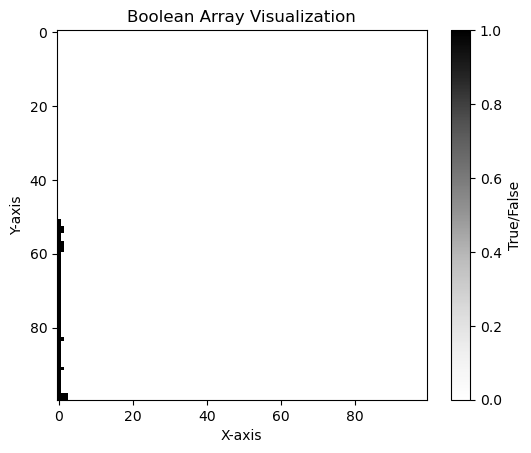

In [286]:
import numpy as np
import matplotlib.pyplot as plt

obs = eval_env.reset()

total_reward = 0
steps = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    steps += 1

    if done:
        break

print(f"{steps} steps with total reward: {total_reward}")

# Plot the boolean array using matplotlib
plt.imshow(eval_env.visited, cmap='Greys', interpolation='none')

# Optional: Add a color bar
plt.colorbar(label="True/False")

# Set axis labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.title("Boolean Array Visualization")
plt.show()

In [28]:
def evaluate_policy(model, env, total_timesteps=1000, num_episodes=5):
    total_rewards = 0
    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        for i in range(total_timesteps):
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                break
            
        total_rewards += episode_reward
    average_reward = total_rewards / num_episodes
    return average_reward

In [29]:
# Train the model
max_runs = 30
total_timesteps = 10000

for epoch in range(max_runs):
    model.learn(total_timesteps=total_timesteps, log_interval=total_timesteps)
    avg_reward = evaluate_policy(model, eval_env, total_timesteps)
    print(f"Epoch {epoch+1} done. Average Reward: {avg_reward}")

Epoch 1 done. Average Reward: -76431.0
Epoch 2 done. Average Reward: -75632.0
Epoch 3 done. Average Reward: -222463.0
Epoch 4 done. Average Reward: -293944.0
Epoch 5 done. Average Reward: -84371.0
Epoch 6 done. Average Reward: -78526.0
Epoch 7 done. Average Reward: -53926.0
Epoch 8 done. Average Reward: -86177.0
Epoch 9 done. Average Reward: -58278.0
Epoch 10 done. Average Reward: -81759.0
Epoch 11 done. Average Reward: -89306.0
Epoch 12 done. Average Reward: -76045.0
Epoch 13 done. Average Reward: -122592.0
Epoch 14 done. Average Reward: -94537.0
Epoch 15 done. Average Reward: -80287.0
Epoch 16 done. Average Reward: -73003.0
Epoch 17 done. Average Reward: -74815.0
Epoch 18 done. Average Reward: -80225.0
Epoch 19 done. Average Reward: -81993.0
Epoch 20 done. Average Reward: -103980.0
Epoch 21 done. Average Reward: -108056.0
Epoch 22 done. Average Reward: -77163.0
Epoch 23 done. Average Reward: -103281.0
Epoch 24 done. Average Reward: -78811.0
Epoch 25 done. Average Reward: -100006.0
Ep

In [37]:
obs = env.reset()

total_reward = 0
steps = 0

for _ in range(total_timesteps):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, info = env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    steps += 1

    if done:
        break

print(f"{steps} steps with total reward: {total_reward}")

10000 steps with total reward: -123425


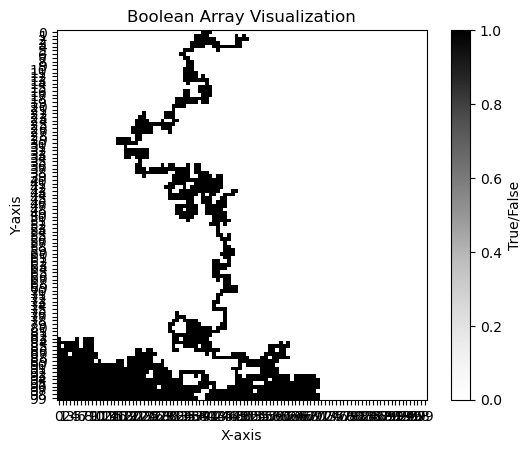

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the boolean array using matplotlib
plt.imshow(env.visited, cmap='Greys', interpolation='none')

# Optional: Add a color bar
plt.colorbar(label="True/False")

# Set ticks
plt.xticks(range(env.visited.shape[1]))
plt.yticks(range(env.visited.shape[0]))

# Set axis labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.title("Boolean Array Visualization")
plt.show()
